In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.graphics.tsaplots import plot_acf 
from statsmodels.graphics.tsaplots import plot_pacf 
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_test = pd.read_csv('/Users/suicideboy/Desktop/Python Projects/Datasets/Climate time series/DailyDelhiClimateTest.csv', parse_dates = ['date'], index_col = 'date')
df_train = pd.read_csv('/Users/suicideboy/Desktop/Python Projects/Datasets/Climate time series/DailyDelhiClimateTrain.csv', parse_dates = ['date'], index_col = 'date')
# importing climate data from Delhi
# I also set the index to be the date and converted these from strings into datetime64[ns] 

In [3]:
df_test.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2017-01-01,15.913043,85.869565,2.743478,59.000000
2017-01-02,18.500000,77.222222,2.894444,1018.277778
2017-01-03,17.111111,81.888889,4.016667,1018.333333
2017-01-04,18.700000,70.050000,4.545000,1015.700000
2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [4]:
df_train.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [5]:
df_train.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
               '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30',
               '2016-12-31', '2017-01-01'],
              dtype='datetime64[ns]', name='date', length=1462, freq=None)

In [6]:
df_train.drop(['humidity', 'wind_speed', 'meanpressure'], axis = 1 ,inplace = True)
df_test.drop(['humidity', 'wind_speed', 'meanpressure'], axis = 1 ,inplace = True)

In [7]:
# we now have our time series 
# I wish to analyse changes in temperature to investigate climate change
df_train = df_train[df_train.index.is_month_start]

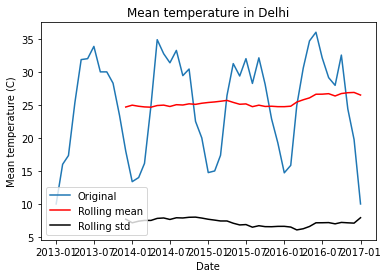

In [8]:
rolling_mean = df_train.rolling(window = 12).mean()
rolling_std = df_train.rolling(window = 12).std()
plt.plot(df_train, label = 'Original')
plt.plot(rolling_mean, c = 'red', label = 'Rolling mean')
plt.plot(rolling_std, c = 'black',label = 'Rolling std')
plt.xlabel('Date')
plt.ylabel('Mean temperature (C)')
plt.title('Mean temperature in Delhi')
plt.legend(loc = 'lower left')
plt.show()
# before building a model, we must ensure the time series is stationary
# we can check this by plotting the rolling mean and rolling standard deviation to see if they constant with time
# they are not but we can use differencing with an ARIMA model to give us a stationary time series 

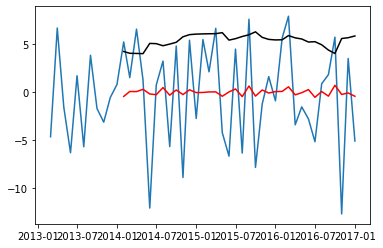

In [9]:
plt.plot(df_train.diff().diff())
plt.plot(df_train.diff().diff().rolling(window = 12).mean(), c = 'red')
plt.plot(df_train.diff().diff().rolling(window = 12).std(), c = 'black')
plt.show()
# using 2nd order differencing to increase the stationary nature of the time series 

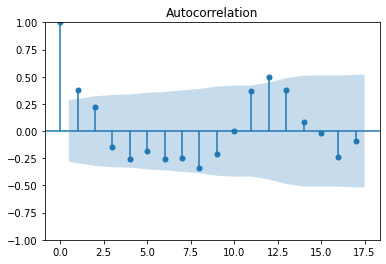

In [10]:
plot_acf(df_train.diff().dropna())
plt.show()
# number of lags crossing the threshold is 2 so q = 2 for our ARIMA model 

In [11]:
print('P-value: ', adfuller(df_train.meantemp.dropna())[1])
print('P-value: ', adfuller(df_train.meantemp.diff().dropna())[1])
print('P-value: ', adfuller(df_train.meantemp.diff().diff().dropna())[1])
# since the p-value for first order differencing is p < 0.05, we have a stationary time series ready for modelling
# this means that d = 1

P-value:  0.8581174519742107
P-value:  2.1757125924808383e-06
P-value:  9.5609140894744e-10


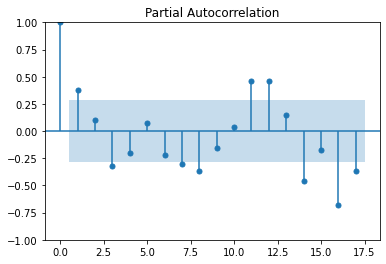

In [12]:
plot_pacf(df_train.meantemp.diff().dropna())
plt.show()
# we have quite a high number of significant lags but I don't want overfitting so I will set p=5

In [13]:
model = ARIMA(df_train, order = (5,1,2), seasonal_order = (5,1,2,12))
arima_model = model.fit()
# due to the seasonal nature of the time series, we include m = 12 since a pattern occurs every 12 months 

In [14]:
print(arima_model.summary())

                                    SARIMAX Results                                     
Dep. Variable:                         meantemp   No. Observations:                   49
Model:             ARIMA(5, 1, 2)x(5, 1, 2, 12)   Log Likelihood                 -85.658
Date:                          Sat, 19 Nov 2022   AIC                            201.317
Time:                                  10:04:17   BIC                            225.069
Sample:                              01-01-2013   HQIC                           209.607
                                   - 01-01-2017                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3376      3.303      0.102      0.919      -6.135       6.810
ar.L2          0.1042      1.503      0.069      0.

In [15]:
prediction = arima_model.predict(start = '2017', end = '2020')
df = pd.DataFrame(prediction)

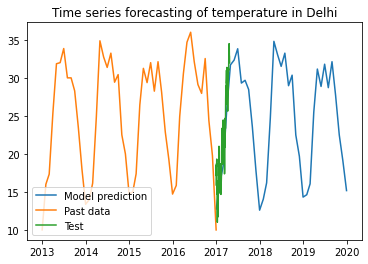

In [16]:
plt.plot(df, label = 'Model prediction')
plt.plot(df_train, label = 'Past data')
plt.plot(df_test, label = 'Test')
plt.legend()
plt.title('Time series forecasting of temperature in Delhi')
plt.show()